In [ ]:
pip install control

     |████████████████████████████████| 348kB 4.0MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=c2ed6723344c51706636f4c4350252deca6d259e3299f522721a4fdc4289b2d7
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
pip install slycot

     |████████████████████████████████| 1.6MB 3.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417833 sha256=191750280de42c9d5472b7e8797b1b356202ffa03ed9c33f88fd7a99b7d4c1f0
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
from control.matlab import *
from control import place
import slycot
from scipy import integrate

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams.update({'font.size': 8})
plt.rcParams['animation.html'] = 'jshtml'

In [ ]:
m = 1
M = 5
L = 2
g = -10
d = 1

b = 1 # pendulum up (b=1)

A = np.array([[0,1,0,0],\
              [0,-d/M,b*m*g/M,0],\
              [0,0,0,1],\
              [0,-b*d/(M*L),-b*(m+M)*g/(M*L),0]])

B = np.array([0,1/M,0,b/(M*L)]).reshape((4,1))

print(np.linalg.eig(A)[0])       # Eigenvalues
print(np.linalg.det(ctrb(A,B)))  # Determinant of controllability matrix

[ 0.         -2.431123   -0.23363938  2.46476238]
0.0196


In [ ]:
A = np.array([[0, 1, 0, 0], [0, -0.2, -2, 0], [0, 0, 0, 1], [0, -0.1, 6, 0]])
B = np.array([[0], [0.2], [0], [0.1]])

print(np.linalg.eig(A)[0])      
print(np.linalg.det(ctrb(A,B)))  

[ 0.         -2.431123   -0.23363938  2.46476238]
0.0196


In [ ]:
## Design LQR Controller
Q = np.eye(4) # 4x4 identity mat
R = 0.01

K = lqr(A,B,Q,R)[0]

In [ ]:
K


matrix([[-10.        , -41.70002299, 518.84431022, 200.06295597]])

In [ ]:
## Design LQR Controller (similar as above)
Q = np.array([[1., 0., 0., 0.],
       [0., 10., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
R = 0.01
K = lqr(A,B,Q,R)[0] 

In [ ]:
## ODE RHS Function Definition
def pendcart(x,t,m,M,L,g,d,uf):
    u = uf(x) # evaluate anonymous function at x
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = m*L*L*(M+m*(1-Cx**2))
    
    dx = np.zeros(4)
    dx[0] = x[1]
    dx[1] = (1/D)*(-(m**2)*(L**2)*g*Cx*Sx + m*(L**2)*(m*L*(x[3]**2)*Sx - d*x[1])) + m*L*L*(1/D)*u
    dx[2] = x[3]
    dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1])) - m*L*Cx*(1/D)*u;
    
    return dx

In [ ]:
## Simulate closed-loop system
tspan = np.arange(0,10,0.001)
x0 = np.array([-1,0,np.pi+0.91,0]) # Initial condition
wr = np.array([1,0,np.pi,0])      # Reference position
u = lambda x: -K@(x-wr)           # Control law

x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))

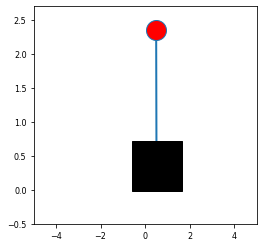

In [ ]:
fig,ax = plt.subplots()
H = 0.5*np.sqrt(M/5)
p_pend, = plt.plot([],[],'o-',linewidth=2,ms=20,markerfacecolor='r')
p_cart, = plt.plot([],[],'ks',ms=50)

x_plot = x[::100,:]
t_plot = tspan[::100]

def init():
    ax.set_xlim(-5,5)
    ax.set_ylim(-0.5, 2.7)
    return x

def animate(iter):
    x_iter = x_plot[iter,0]
    th_iter = x_plot[iter,2]
    
    p_cart.set_data(x_iter,0.1+H/2)
    p_pend.set_data(x_iter+np.array([0,L*np.sin(th_iter)]),\
                    0.1+H/2+np.array([0,-L*np.cos(th_iter)]))
    return p_pend

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(t_plot),interval=50,blit=False,repeat=False)
HTML(anim.to_jshtml())